In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable, Tuple, Any
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Burgers
problem = Burgers()

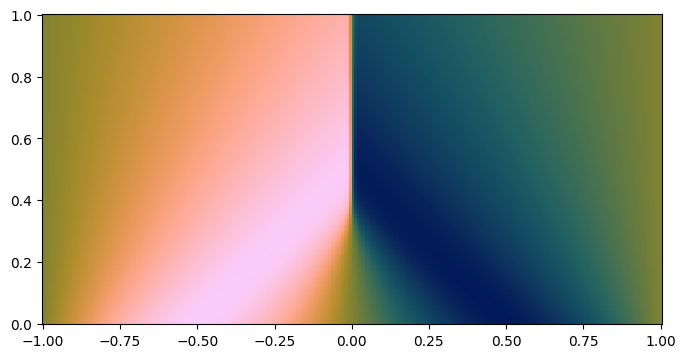

In [3]:
X, T, u_solution = problem.exact_solution(nx=256, nt=256)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax_exact = ax.pcolormesh(X, T, u_solution, cmap=cmap)

In [4]:
import optax
from jax.flatten_util import ravel_pytree

class BFGS:
    """
    BFGS optimiser with a robust Wolfe line search and Nocedal & Wright Hessian scaling.
    This version includes robust failure handling for the line search.
    """

    def __init__(
        self,
        c1=1e-4,
        c2=0.9,
        max_ls_steps=20,
        alpha_init=1.0,
    ):
        """
        Initialises the BFGS optimiser.
        
        Args:
            c1 (float): Armijo condition constant.
            c2 (float): Curvature condition constant.
            max_ls_steps (int): Maximum steps for line search.
            alpha_init (float): Initial step size guess.
        """
        self.c1 = c1
        self.c2 = c2
        self.max_ls_steps = max_ls_steps
        self.alpha_init = alpha_init

    def init(self, params):
        """
        Initialises the optimizer state.
        
        Returns:
            dict: The initial state dictionary.
        """
        params_flat, _ = ravel_pytree(params)
        num_params = params_flat.size
        return {
            # H_inv is the inverse Hessian approximation
            'H_inv': jnp.eye(num_params),
            # x_prev is the parameters from the previous step
            'x_prev': params_flat,
            # g_prev is the gradient from the previous step
            'g_prev': jnp.zeros_like(params_flat),
            # is_first_step is a flag to apply initial Hessian scaling
            'is_first_step': jnp.array(True, dtype=bool)
        }

    def _line_search(
        self,
        loss_fn,
        params,
        current_loss,
        current_grad,
        p_k,
        unflatten,
        params_flat,
        current_grad_flat,
    ):
        """
        Performs a robust Wolfe line search to find an appropriate step size.
        """
        
        # Helper function to check Armijo and curvature conditions
        def check_wolfe_conditions(alpha, new_loss, new_grad, directional_derivative):
            # Armijo condition: new_loss <= current_loss + c1 * alpha * directional_derivative
            armijo_cond = new_loss <= current_loss + self.c1 * alpha * directional_derivative
            
            # Curvature condition: new_directional_derivative >= c2 * directional_derivative
            new_grad_flat, _ = ravel_pytree(new_grad)
            new_directional_derivative = jnp.dot(new_grad_flat, p_k)
            curvature_cond = new_directional_derivative >= self.c2 * directional_derivative
            
            return armijo_cond, curvature_cond, new_directional_derivative, new_grad_flat

        # Loop body for the while_loop
        def loop_body(state):
            alpha, ls_steps, new_loss, _, _, _, _ = state
            
            # Compute the flat update vector s_k
            s_k_flat = alpha * p_k
            
            # Update flat parameters directly
            temp_new_params_flat = params_flat + s_k_flat
            
            # Unflatten to get the new parameters tree for loss evaluation
            new_params_tree = unflatten(temp_new_params_flat)
            
            # Evaluate loss and gradient
            new_loss, new_grad = jax.value_and_grad(loss_fn)(new_params_tree)
            new_grad_flat, _ = ravel_pytree(new_grad)

            directional_derivative = jnp.dot(current_grad_flat, p_k)
            armijo_cond = new_loss <= current_loss + self.c1 * alpha * directional_derivative
            curvature_cond = jnp.dot(new_grad_flat, p_k) >= self.c2 * directional_derivative
            
            cond_met = armijo_cond & curvature_cond
            
            new_alpha = jax.lax.cond(cond_met, lambda: alpha, lambda: alpha * 0.5)
            is_successful = armijo_cond # and curvature_cond, or handle differently based on desired robustness
            
            return (new_alpha, ls_steps + 1, new_loss, new_params_tree, new_grad, is_successful, cond_met)

        # Initial loop state
        initial_state = (self.alpha_init, 0, jnp.inf, params, current_grad, False, False)
        
        # While loop to perform line search
        final_alpha, final_ls_steps, final_loss, final_params, final_grad, is_successful, conditions_met = jax.lax.while_loop(
            lambda state: (state[1] < self.max_ls_steps) & ~state[6], # Loop while steps < max and conditions not met
            loop_body,
            initial_state
        )
        
        return final_loss, final_params, final_grad, final_alpha, final_ls_steps, is_successful


    def _handle_successful_step(self, H_inv, x_k, g_k, g_k_plus_1, p_k, alpha, is_first_step):
        """Calculates updates and new H_inv for a successful step."""
        s_k = alpha * p_k
        y_k = g_k_plus_1 - g_k

        # Nocedal & Wright scaling
        # Initially, scale the Hessian approximation
        H_inv_scaled = jax.lax.cond(
            is_first_step,
            lambda: H_inv * (jnp.dot(y_k, s_k) / jnp.dot(y_k, y_k)),
            lambda: H_inv
        )
        
        rho_k = 1.0 / jnp.dot(y_k, s_k)
        
        # BFGS update formula
        term1 = jnp.eye(H_inv.shape[0]) - rho_k * jnp.outer(s_k, y_k)
        term2 = jnp.eye(H_inv.shape[0]) - rho_k * jnp.outer(y_k, s_k)
        H_inv_new = jnp.dot(jnp.dot(term1, H_inv_scaled), term2) + rho_k * jnp.outer(s_k, s_k)
        
        updates = s_k
        new_params_flat = x_k + s_k
        
        return updates, H_inv_new, new_params_flat

    def _handle_failed_step(self, H_inv, x_k):
        """Handles a line search failure by resetting the Hessian and zeroing updates."""
        updates = jnp.zeros_like(x_k)
        H_inv_new = jnp.eye(H_inv.shape[0])  # Reset to identity
        new_params_flat = x_k # No update
        return updates, H_inv_new, new_params_flat

    def update(
        self,
        params,
        state,
        loss_fn,
    ):
        """
        Updates the parameters using the BFGS algorithm.
        
        Args:
            params (eqx.Module): The current model parameters.
            state (optax.OptState): The current optimizer state.
            loss_fn (Callable): The loss function.
        
        Returns:
            Tuple: A tuple containing the new loss, parameter updates, new state, and metrics.
        """
        H_inv = state['H_inv']
        g_prev = state['g_prev']

        # JAX's `value_and_grad` computes both the loss and gradient efficiently.
        (current_loss, current_grad) = jax.value_and_grad(loss_fn)(params)
        current_grad_flat, unflatten = ravel_pytree(current_grad)
        params_flat, _ = ravel_pytree(params)
        
        # Compute the search direction: p_k = -H_inv * grad
        p_k = -jnp.dot(H_inv, current_grad_flat)
        
        # Perform Wolfe line search to find the step size alpha
        new_loss, new_params_tree, new_grad, alpha, ls_steps, is_successful_step = self._line_search(
            loss_fn, params, current_loss, current_grad, p_k, unflatten, params_flat, current_grad_flat
        )
        
        new_grad_flat, _ = ravel_pytree(new_grad)

        # Use a conditional to handle successful vs. failed steps
        updates_flat, H_inv_new, new_params_flat = jax.lax.cond(
            is_successful_step,
            # Successful step: calculate updates and new H_inv
            lambda: self._handle_successful_step(
                H_inv, params_flat, current_grad_flat, new_grad_flat, p_k, alpha, state['is_first_step']
            ),
            # Failed step: zero updates and reset H_inv
            lambda: self._handle_failed_step(H_inv, params_flat)
        )
        
        updates = unflatten(updates_flat)

        new_state = {
            'H_inv': H_inv_new,
            'x_prev': new_params_flat,
            'g_prev': new_grad_flat,
            'is_first_step': jnp.array(False, dtype=bool)
        }

        metrics = {
            'loss': new_loss,
            'alpha': alpha,
            'line_search_steps': ls_steps,
            'search_direction_norm': jnp.linalg.norm(p_k),
        }

        return new_loss, updates, new_state, metrics



# class BFGS:
#     """
#     BFGS optimiser with a simple backtracking line search and Nocedal & Wright Hessian scaling.
#     This version uses a simple Armijo-based line search for robustness.
#     """

#     def __init__(
#         self,
#         c1: float = 1e-4,
#         max_ls_steps: int = 20,
#         alpha_init: float = 1.0,
#     ):
#         """
#         Initialises the BFGS optimiser.
        
#         Args:
#             c1 (float): Armijo condition constant.
#             max_ls_steps (int): Maximum steps for line search.
#             alpha_init (float): Initial step size guess.
#         """
#         self.c1 = c1
#         self.max_ls_steps = max_ls_steps
#         self.alpha_init = alpha_init

#     def init(self, params: eqx.Module) -> optax.OptState:
#         """
#         Initialises the optimizer state.
        
#         Returns:
#             dict: The initial state dictionary.
#         """
#         params_flat, _ = ravel_pytree(params)
#         num_params = params_flat.size
#         return {
#             # H_inv is the inverse Hessian approximation
#             'H_inv': jnp.eye(num_params),
#             # x_prev is the parameters from the previous step
#             'x_prev': params_flat,
#             # g_prev is the gradient from the previous step
#             'g_prev': jnp.zeros_like(params_flat),
#             # is_first_step is a flag to apply initial Hessian scaling
#             'is_first_step': jnp.array(True, dtype=bool)
#         }

#     def update(
#         self,
#         params: eqx.Module,
#         state: optax.OptState,
#         loss_fn: Callable[[eqx.Module], jax.Array],
#     ) -> Tuple[jax.Array, Any, optax.OptState, dict]:
#         """
#         Updates the parameters using the BFGS algorithm.
        
#         Args:
#             params (eqx.Module): The current model parameters.
#             state (optax.OptState): The current optimizer state.
#             loss_fn (Callable): The loss function.
        
#         Returns:
#             Tuple: A tuple containing the new loss, parameter updates, new state, and metrics.
#         """
#         H_inv = state['H_inv']
#         params_flat, unflatten = ravel_pytree(params)
#         g_prev = state['g_prev']
#         is_first_step = state['is_first_step']

#         # Compute the loss and gradient for the current parameters
#         current_loss, current_grad = jax.value_and_grad(loss_fn)(params)
#         current_grad_flat, _ = ravel_pytree(current_grad)
        
#         # Compute the search direction: p_k = -H_inv * grad
#         p_k = -jnp.dot(H_inv, current_grad_flat)
        
#         # Perform backtracking line search to find a suitable step size alpha
#         alpha, ls_steps, new_loss, new_params_tree, new_grad_flat = self._backtracking_line_search(
#             loss_fn, params, p_k, current_loss, current_grad_flat, unflatten
#         )

#         # Flatten the new parameters before subtracting
#         new_params_flat, _ = ravel_pytree(new_params_tree)

#         # Calculate parameter updates from the chosen step size
#         updates_flat = new_params_flat - params_flat
        
#         # If line search fails, updates are zero and Hessian is reset
#         is_successful = (ls_steps < self.max_ls_steps)
#         updates_flat = jax.lax.cond(is_successful, lambda: updates_flat, lambda: jnp.zeros_like(updates_flat))
        
#         # Calculate BFGS updates for H_inv based on a successful step
#         s_k = updates_flat
#         delta_g = new_grad_flat - current_grad_flat
#         is_positive_curvature = jnp.dot(delta_g, s_k) > 1e-8
        
#         H_inv_new = jax.lax.cond(
#             is_successful & is_positive_curvature,
#             lambda: (jnp.eye(H_inv.shape[0]) - jnp.outer(s_k, delta_g) / jnp.dot(delta_g, s_k)) @ H_inv @ \
#                     (jnp.eye(H_inv.shape[0]) - jnp.outer(delta_g, s_k) / jnp.dot(delta_g, s_k)) + \
#                     jnp.outer(s_k, s_k) / jnp.dot(delta_g, s_k),
#             lambda: jnp.eye(H_inv.shape[0]) # Reset the Hessian
#         )
        
#         updates = unflatten(updates_flat)

#         new_state = {
#             'H_inv': H_inv_new,
#             'x_prev': new_params_flat,
#             'g_prev': new_grad_flat,
#             'is_first_step': jnp.array(False, dtype=bool)
#         }

#         metrics = {
#             'loss': new_loss,
#             'alpha': alpha,
#             'line_search_steps': ls_steps,
#             'search_direction_norm': jnp.linalg.norm(p_k),
#         }

#         return new_loss, updates, new_state, metrics

#     def _backtracking_line_search(self, loss_fn, params, p_k, f_k, g_k, unflatten):
#         """
#         A simple backtracking line search implementation that only checks the Armijo condition.
        
#         Returns:
#             Tuple[float, int, jax.Array, jax.Array, jax.Array]:
#             alpha, steps, new_loss, new_params_flat, new_grad_flat
#         """
        
#         # Function to check the Armijo condition
#         def check_armijo(alpha, f_trial, f_k, g_k, p_k, c1):
#             return f_trial <= f_k + c1 * alpha * jnp.dot(g_k, p_k)

#         # Loop body for the while_loop
#         def ls_step(loop_val):
#             alpha, step_count, _, _ = loop_val
            
#             # Reduce step size
#             new_alpha = alpha * 0.9
            
#             # Evaluate loss and gradient for the next trial alpha
#             params_next = eqx.apply_updates(params, unflatten(new_alpha * p_k))
#             f_trial_next, g_trial_next = jax.value_and_grad(loss_fn)(params_next)
#             g_trial_next_flat, _ = ravel_pytree(g_trial_next)

#             armijo_satisfied = check_armijo(new_alpha, f_trial_next, f_k, g_k, p_k, self.c1)

#             return (new_alpha, step_count + 1, f_trial_next, g_trial_next_flat)

#         # The loop condition
#         def continue_ls(loop_val):
#             alpha, step_count, f_trial, g_trial_flat = loop_val
#             armijo_satisfied = check_armijo(alpha, f_trial, f_k, g_k, p_k, self.c1)
#             # Continue if Armijo not satisfied and max steps not reached
#             return jnp.logical_not(armijo_satisfied) & (step_count < self.max_ls_steps)

#         # Initial values for the while loop
#         initial_alpha = self.alpha_init
#         params_init_try = eqx.apply_updates(params, unflatten(initial_alpha * p_k))
#         f_init_try, g_init_try = jax.value_and_grad(loss_fn)(params_init_try)
#         g_init_try_flat, _ = ravel_pytree(g_init_try)
        
#         initial_ls_val = (initial_alpha, 0, f_init_try, g_init_try_flat)

#         final_alpha, final_steps, final_loss, final_grad_flat = jax.lax.while_loop(continue_ls, ls_step, initial_ls_val)

#         return final_alpha, final_steps, final_loss, eqx.apply_updates(params, unflatten(final_alpha * p_k)), final_grad_flat

    
# class LBFGSWrapper:
#     """
#     A wrapper for the Optax L-BFGS optimizer that exposes it with a custom
#     single-step update method.
#     """

#     def __init__(
#         self,
#         learning_rate: float = 1.0,
#         # use_line_search: bool = True,
#         # c1: float = 1e-4,
#         # c2: float = 0.9,
#         memory_size: int = 50,
#     ):
#         self.learning_rate = learning_rate
#         # self.use_line_search = use_line_search
#         # self.c1 = c1
#         # self.c2 = c2
#         self.memory_size = memory_size

#         # Initialize the underlying Optax L-BFGS optimizer
#         self.optax_lbfgs = optax.lbfgs(
#             learning_rate=self.learning_rate,
#             memory_size=self.memory_size,
#             linesearch=optax.scale_by_backtracking_linesearch(
#                 max_backtracking_steps=100,
#             )
#         )

#     def init(self, params: eqx.Module) -> optax.OptState:
#         return self.optax_lbfgs.init(params)

#     def update(
#         self,
#         params: eqx.Module,
#         state: optax.OptState,
#         loss_fn: Callable[[eqx.Module], jax.Array],
#     ) -> Tuple[jax.Array, Any, optax.OptState, dict]:

#         current_loss, current_grad = jax.value_and_grad(loss_fn)(params)
        
#         updates, new_state = self.optax_lbfgs.update(
#             current_grad, state,
#             value=current_loss,
#             grad=current_grad,
#             value_fn=loss_fn,
#             params=params
#         )
                        
#         new_params = eqx.apply_updates(params, updates)
#         new_loss, _ = jax.value_and_grad(loss_fn)(new_params)
        
#         # line_search_state = new_state[1]
#         metrics = {
#             'loss': new_loss,
#             # 'alpha': line_search_state.alpha,
#             # 'line_search_steps': line_search_state.ls_steps,
#         }

#         return new_loss, updates, new_state, metrics
    
    
@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points, key):
    key, subkey = jax.random.split(key)

    def loss_fn_for_optimizer(p):
        rebuilt_model = eqx.combine(p, static_parts)
        vectorized_physics_residual = jax.vmap(
            problem.physics_residual, in_axes=(None, 0)
        )
        residuals = vectorized_physics_residual(rebuilt_model, collocation_points)
        return jnp.mean(residuals**2)

    loss, updates, new_opt_state, metrics = optimiser.update(
        params, opt_state, loss_fn_for_optimizer
    )
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics, key


@partial(jax.jit, static_argnums=(2, 3, 4, 5))
def resample_rad(
    model, candidate_points, n_points_to_sample, problem, k, c, key
):
    # 1. Calculate PDE residuals for all candidate points
    vmapped_residual_fn = jax.vmap(problem.physics_residual, in_axes=(None, 0))
    residuals = vmapped_residual_fn(model, candidate_points)
        
    # 2. Compute sampling probability based on the RAD formula
    epsilon_k = jnp.abs(residuals)**k
    weights = (epsilon_k / jnp.mean(epsilon_k)) + c
    probs = weights / jnp.sum(weights)

    # 3. Sample new points based on the calculated probabilities
    indices = jax.random.choice(
        key,  a=candidate_points.shape[0], shape=(n_points_to_sample,), p=probs, replace=False
    )
    
    return candidate_points[indices]

In [5]:
key = jax.random.PRNGKey(42)

layer_sizes = [2, 20, 20, 20, 20, 1]

model_key, sample_key = jax.random.split(key, 2)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()

start_time = time.monotonic()

epoch = 0

<function matplotlib.pyplot.show(close=None, block=None)>

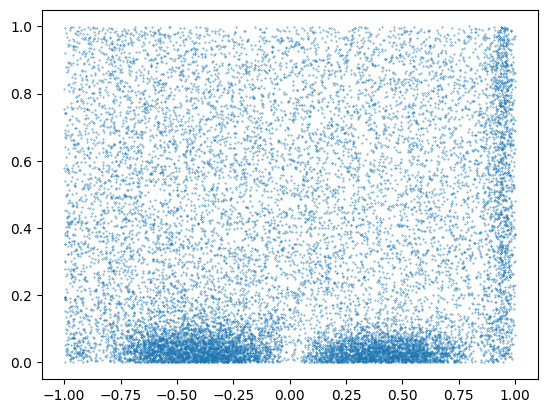

In [6]:
model = eqx.combine(params, static) 

# --- New Hyperparameters for RAD ---
resample_every_n_epochs = 200
rad_k = 1.5
rad_c = 1.0

n_collocation_points = 2**14
n_candidate_points = 20 * n_collocation_points

from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=2, seed=2)
samples = sampler.random(n=n_candidate_points)
l_bounds = [-1, 0]
u_bounds = [1, 1]
scaled_samples = qmc.scale(samples, l_bounds, u_bounds)
candidate_points = jnp.array(scaled_samples)
sample_key, subkey = jax.random.split(sample_key, 2)
collocation_points = resample_rad(
    model, 
    candidate_points, 
    n_collocation_points, 
    problem,
    rad_k,
    rad_c,
    subkey
)
    
plt.scatter(collocation_points[:, 0], collocation_points[:, 1], s=0.1)
plt.show

In [7]:
optimiser = BFGS(
    max_ls_steps=50,
)
opt_state = optimiser.init(params)

import time

total_train_step_time = 0

In [13]:

for _ in range(1000):

    if epoch % resample_every_n_epochs == 0 and epoch > 0:
        sample_key, subkey = jax.random.split(sample_key, 2)
        
        model = eqx.combine(params, static) 
        
        collocation_points = resample_rad(
            model, 
            candidate_points, 
            n_collocation_points, 
            problem,
            rad_k,
            rad_c,
            subkey
        )

    start_train_step_time = time.monotonic()

    params, opt_state, loss_val, metrics, key = train_step(
        params, static, opt_state, optimiser, problem, collocation_points, key
    )
    
    end_train_step_time = time.monotonic()
    total_train_step_time += (end_train_step_time - start_train_step_time)

    if (epoch) % 50 == 0:
        model = eqx.combine(params, static)
        
        u_pred = model.predict(X, T)
        error = np.abs(u_solution - u_pred)
        rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)
        
        metrics["rell2error"] = rel_l2_error
        
        metrics["time"] = total_train_step_time
        
        history.record(metrics)
        
        if (epoch) % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss_val.item():.3e}, Time elapsed: {total_train_step_time:.2f} s")
            
            print(f"{rel_l2_error:.3e}", f"{total_train_step_time:.3f}")

    epoch += 1

model = eqx.combine(params, static)
print("Training complete.")

Epoch 4000, Loss: 9.196e-06, Time elapsed: 54.00 s
5.503e-04 54.003
Epoch 4050, Loss: 6.566e-06, Time elapsed: 54.45 s
5.079e-04 54.450
Epoch 4100, Loss: 6.334e-06, Time elapsed: 54.90 s
4.974e-04 54.901
Epoch 4150, Loss: 6.218e-06, Time elapsed: 56.25 s
5.161e-04 56.254
Epoch 4200, Loss: nan, Time elapsed: 62.29 s
5.159e-04 62.293
Epoch 4250, Loss: 7.591e-06, Time elapsed: 62.89 s
5.471e-04 62.893
Epoch 4300, Loss: 6.356e-06, Time elapsed: 63.25 s
5.355e-04 63.248
Epoch 4350, Loss: 6.094e-06, Time elapsed: 63.60 s
5.165e-04 63.599
Epoch 4400, Loss: 1.072e-05, Time elapsed: 63.96 s
4.730e-04 63.956
Epoch 4450, Loss: 6.161e-06, Time elapsed: 64.31 s
4.861e-04 64.309
Epoch 4500, Loss: 6.035e-06, Time elapsed: 65.40 s
4.916e-04 65.403
Epoch 4550, Loss: nan, Time elapsed: 71.54 s
4.915e-04 71.536
Epoch 4600, Loss: nan, Time elapsed: 77.80 s
4.915e-04 77.798
Epoch 4650, Loss: 6.984e-06, Time elapsed: 78.42 s
5.528e-04 78.418
Epoch 4700, Loss: 6.052e-06, Time elapsed: 78.78 s
5.387e-04 78.78

In [ ]:
burgerslm_l2err = history.history["rell2error"][:10000]
burgerslm_loss = history.history["loss"][:10000]
# burgerslm_lambda = history.history["lambda"][:500]
burgerslm_searchdirnorm = history.history["search_direction_norm"][:10000]
burgerslm_time = history.history["time"][:10000]
# burgerslm_svs = history.history["singular_values"][:500]


np.save('burgersBFGS_l2err.npy', burgerslm_l2err)
np.save('burgersBFGS_loss.npy', burgerslm_loss)
np.save('burgersBFGS_time.npy', burgerslm_time)
np.save('burgersBFGS_searchdirnorm.npy', burgerslm_searchdirnorm)
# np.save('burgersBFGS_svs.npy', burgerslm_svs)
np.save('burgersBFGS_u_pred.npy', u_pred)
np.save('burgersBFGS_u_solution.npy', u_solution)
np.save('burgersBFGS_X.npy', X)
np.save('burgersBFGS_T.npy', T)

Relative L2 Error: 1.624e-04


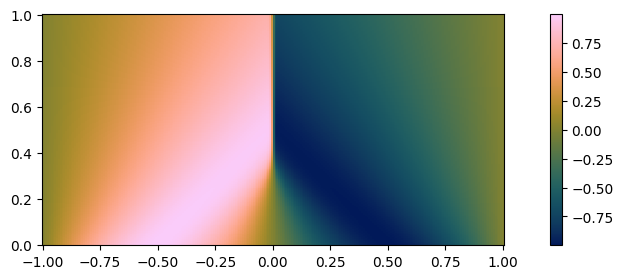

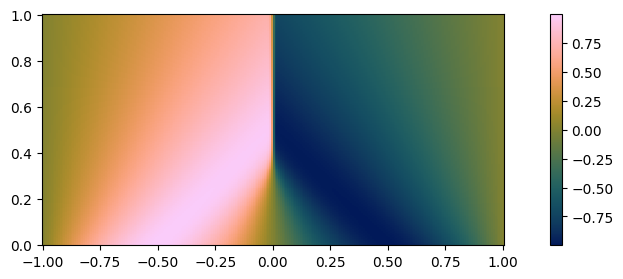

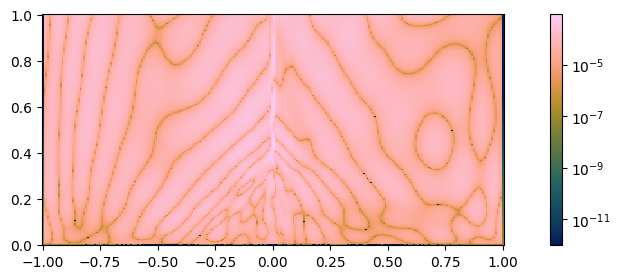

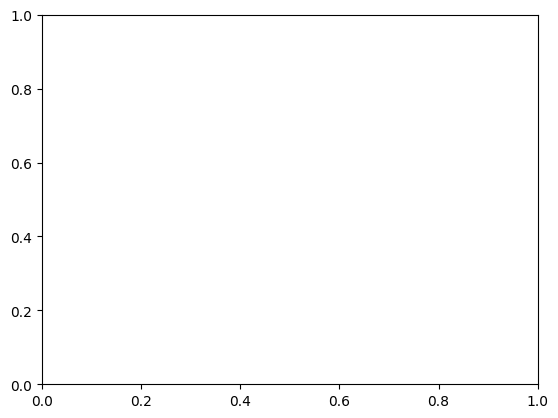

In [ ]:
model = eqx.combine(params, static)

u_pred = model.predict(X, T)

error = np.abs(u_solution - u_pred)
rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
ax_sol = ax.pcolormesh(X, T, u_solution, cmap=cmap)
fig.colorbar(ax_sol, ax=ax, pad=0.05)
plt.show()

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
ax_nn = ax.pcolormesh(X, T, u_pred, cmap=cmap)
fig.colorbar(ax_nn, ax=ax, pad=0.05)
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-12, vmax=error.max())
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-12, norm=norm, cmap=cmap)
fig.colorbar(nn_error, ax=ax, pad=0.05)
plt.show()

fig, ax = plt.subplots()
plt.show()

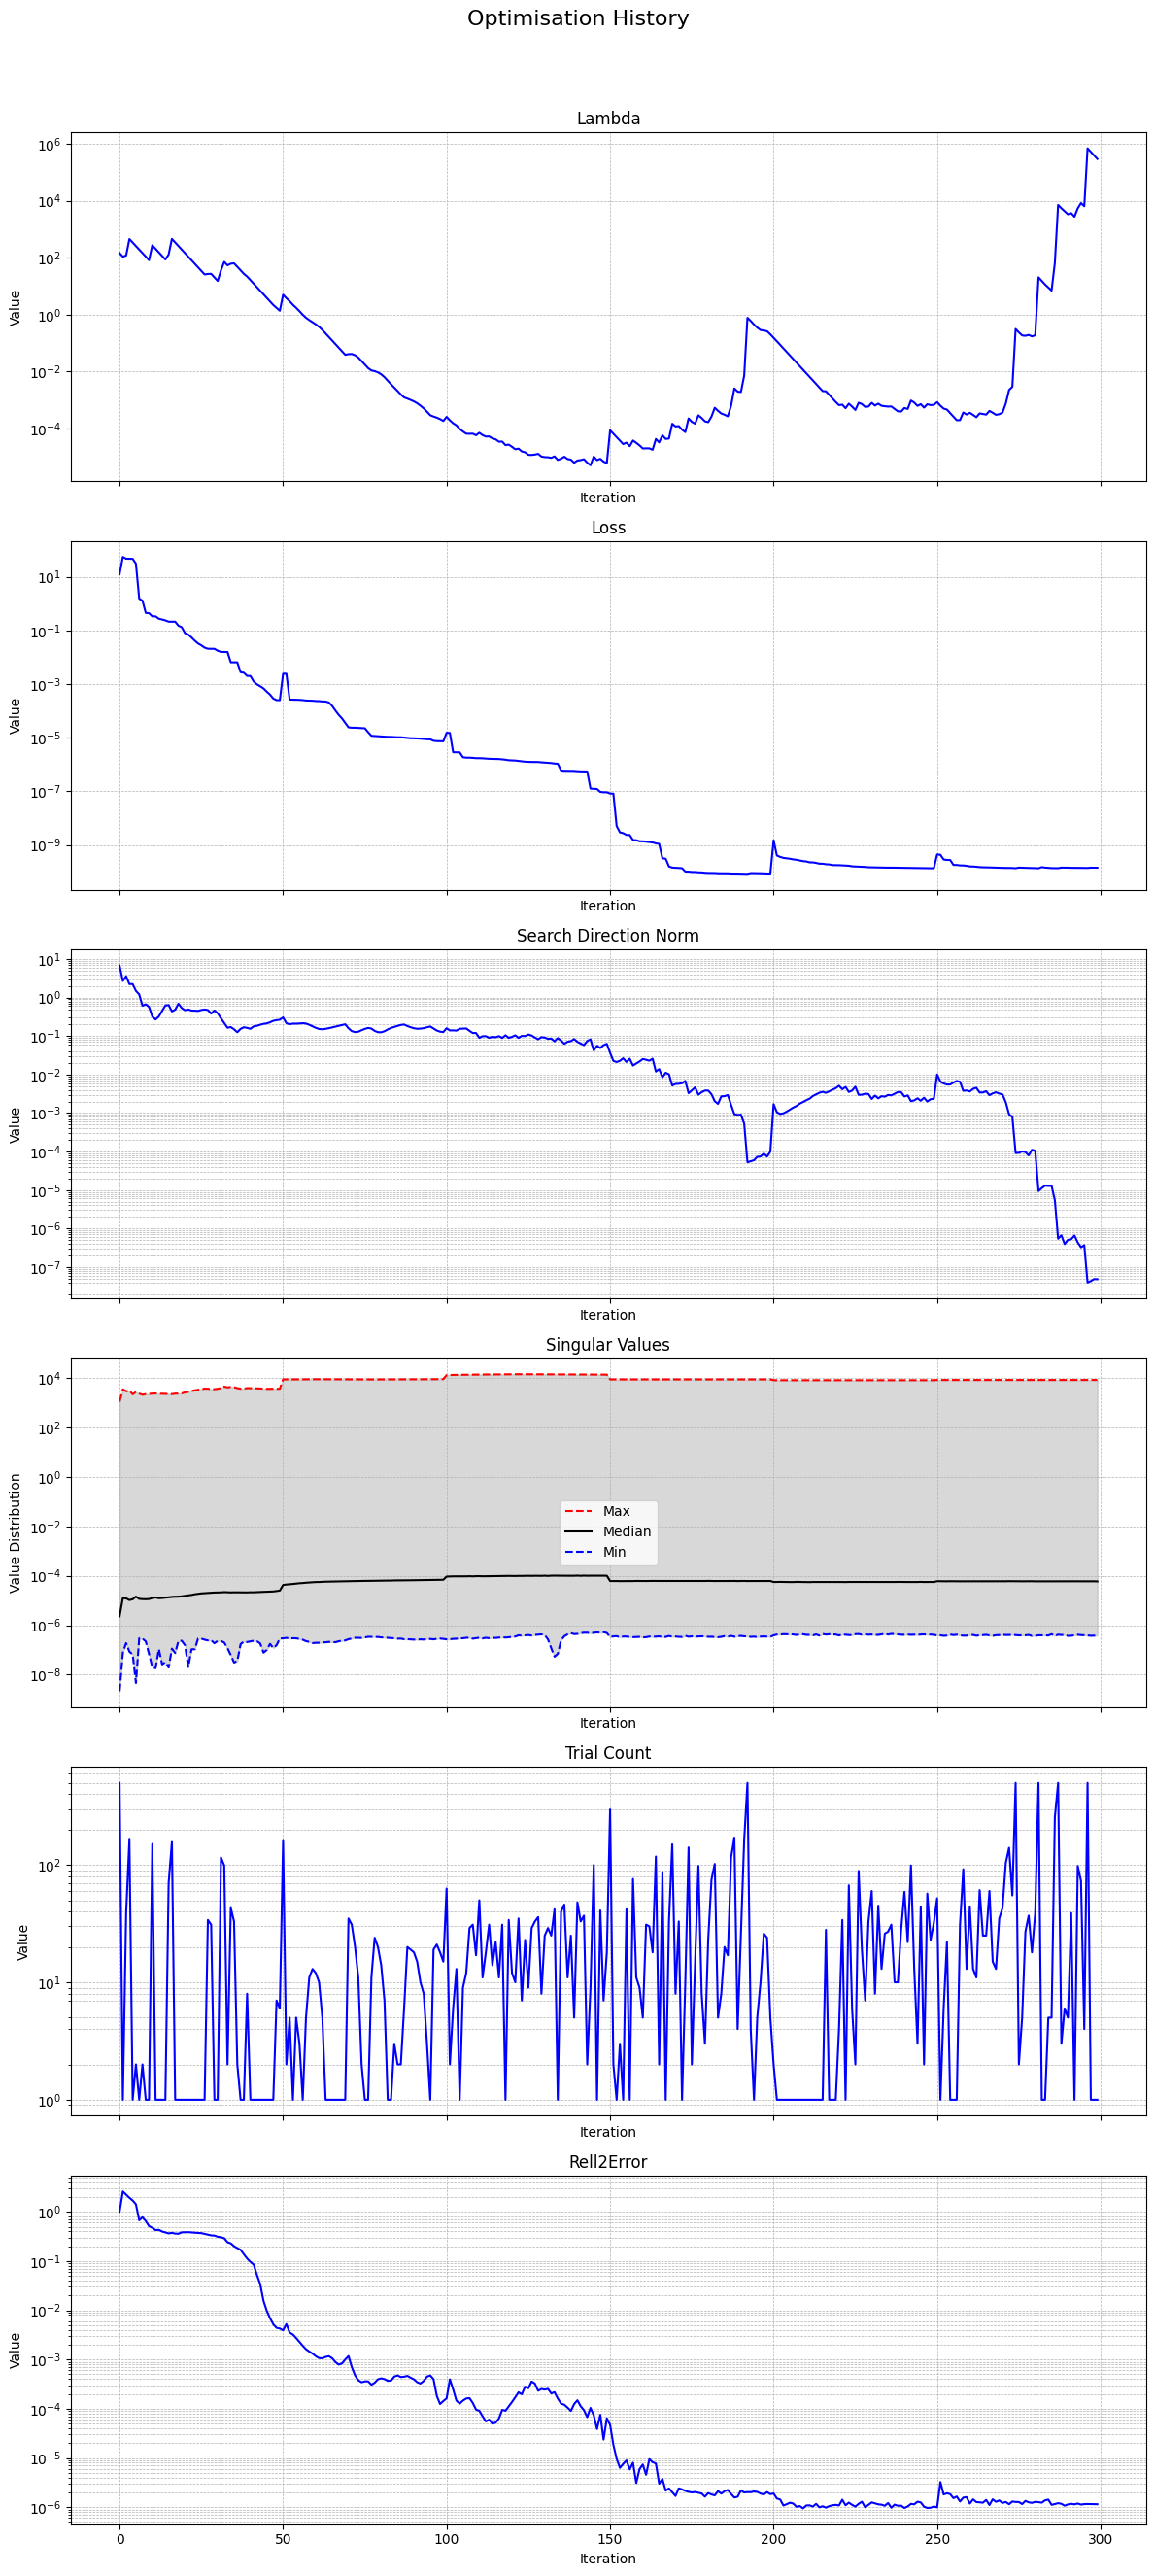

In [ ]:
history.plot()

In [ ]:
import scienceplots

plt.style.use(['science', 'no-latex'])

In [ ]:
burgerslm_l2err = history.history["rell2error"][:500]
burgerslm_loss = history.history["loss"][:500]
burgerslm_lambda = history.history["lambda"][:500]
burgerslm_searchdirnorm = history.history["search_direction_norm"][:500]
burgerslm_svs = history.history["singular_values"][:500]


np.save('burgerslm_l2err.npy', burgerslm_l2err)
np.save('burgerslm_loss.npy', burgerslm_loss)
np.save('burgerslm_lambda.npy', burgerslm_lambda)
np.save('burgerslm_searchdirnorm.npy', burgerslm_searchdirnorm)
np.save('burgerslm_svs.npy', burgerslm_svs)

np.save('burgerslm_u_pred.npy', u_pred)
np.save('burgerslm_u_solution.npy', u_solution)
np.save('burgerslm_X.npy', X)
np.save('burgerslm_T.npy', T)

In [ ]:
print(np.min(burgerslm_l2err))

print(burgerslm_l2err[-1])

9.043599306804823e-07
9.557610694701962e-07


<function matplotlib.pyplot.show(close=None, block=None)>

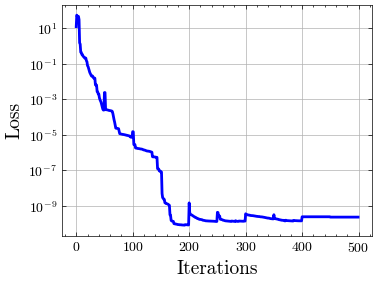

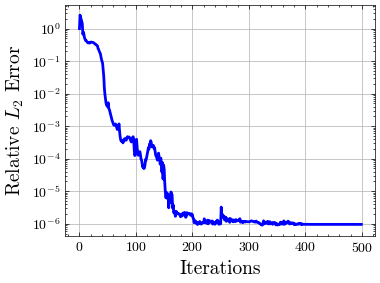

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(burgerslm_loss, color='b', linestyle='-', linewidth=2)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'Loss', fontsize=14)
plt.grid()
plt.show

plt.figure(figsize=(4, 3))
plt.plot(burgerslm_l2err, color='b', linestyle='-', linewidth=2)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'Relative $L_2$ Error', fontsize=14)
plt.grid()
plt.show

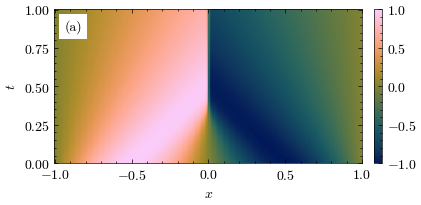

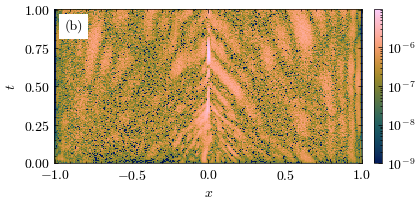

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_aspect("equal")
ax_nn = ax.pcolormesh(X, T, u_pred, cmap=cmap, rasterized=True,
                      vmin=-1,vmax=1)
fig.colorbar(ax_nn, ax=ax, pad=0.03)
ax.annotate("(a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(7, -7), textcoords='offset points',
            ha='left', va='top',
            bbox=dict(facecolor='white', alpha=1.0, linewidth=0))
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.savefig("burgers_lm.pdf", format="pdf")
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-9, vmax=error.max())
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-9, norm=norm, cmap=cmap, rasterized=True,)
fig.colorbar(nn_error, ax=ax, pad=0.03)
ax.annotate("(b)", xy=(0, 1), xycoords='axes fraction',
            xytext=(7, -7), textcoords='offset points',
            ha='left', va='top',
            bbox=dict(facecolor='white', alpha=1.0, linewidth=0))
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.savefig("burgers_lm_err.pdf", format="pdf")
plt.show()